In [1]:
from langchain_core.messages import HumanMessage
from app.src.graph import build_scrape_graph, build_scrape_graphv2, build_url_graph, build_graph, build_analize_graph

graph = build_analize_graph(model='ollama', temperature=0.0)

#user_input = input("Enter a message: ")
user_input = "quiero un depto en la plata para una persona moderno con cochera"
print(user_input)
state = graph.invoke({"query": [HumanMessage(content=user_input)]})

print(state["analysis"])

quiero un depto en la plata para una persona moderno con cochera
Accessing webpage: https://www.zonaprop.com.ar/departamentos-alquiler-la-plata-1-habitacion-1-garage.html
[AIMessage(content='Okay, here\'s a breakdown of the listings that seem to best fit your request for a modern, one-person apartment in La Plata with a garage, based on the provided data. I\'ll rank them and explain why.  I\'m focusing on "modern" as meaning relatively new, well-equipped, and potentially with some amenities.\n\n**Top Recommendations (Best Fit)**\n\n1.  **Listing ID: 55861059 (City Bell - Camino General Belgrano)**\n    *   **Why it\'s a good fit:** This is the strongest contender.\n        *   **Location:** City Bell is a desirable, modern area of La Plata.\n        *   **Type:** It\'s a duplex, which often implies a more modern design and layout.\n        *   **Garage:** Includes a garage.\n        *   **Modern Features:**  Mentioned as having "modern design and layout" and includes air conditioning (

In [1]:
from langchain_core.messages import HumanMessage
from app.src.graph import build_graph

graph = build_graph(model='ollama', temperature=0.0)

#user_input = input("Enter a message: ")
user_input = "quiero un depto en la plata para una persona moderno con cochera"
print(user_input)
state = graph.invoke({"query": [HumanMessage(content=user_input)]})

print(state["query"][-1].content)

quiero un depto en la plata para una persona moderno con cochera
Accessing webpage: https://www.zonaprop.com.ar/departamentos-alquiler-la-plata-1-garage.html
Okay, here's a breakdown of the properties from the provided data that seem to best fit your request for a modern, one-person apartment in La Plata with a garage, along with a summary table.  I'm prioritizing "modern" based on features like balconies, updated kitchens (though details are limited), and overall descriptions suggesting a newer or well-maintained property.

**Understanding the Challenge:**

The descriptions are somewhat limited. "Modern" is subjective, and I'm interpreting it as newer, well-maintained, and potentially with some desirable features.  The data focuses on the basics.

**Top Recommendations (Based on the Data):**

Here's a prioritized list, with explanations.  I'm also including a summary table at the end.

1.  **ID: 55854095 (Calle 6 y 62)**
    *   **Price:** $600,000 rent + $160,000 expenses = $760,000 

In [9]:
import json

try:
    with open("analysis.md", 'w', encoding='utf-8') as file:
        file.write(state["analysis"][-1].content)
    print(f"String successfully saved to '{"analysis.md"}'")
except Exception as e:
    print(f"An error occurred: {e}")    

try:
    with open("result.md", 'w', encoding='utf-8') as file:
        file.write(state["query"][-1].content)
    print(f"String successfully saved to '{"result.md"}'")
except Exception as e:
    print(f"An error occurred: {e}")    

with open("apartments.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(state["properties"], indent=2, ensure_ascii=False))


String successfully saved to 'analysis.md'
String successfully saved to 'result.md'


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_community.chat_models import ChatOllama
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from pydantic.networks import AnyUrl
from langchain_core.messages import HumanMessage


In [3]:
load_dotenv()

llm = init_chat_model("ollama:deepseek-r1:latest")


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


graph = graph_builder.compile()

user_input = input("Enter a message: ")
state = graph.invoke({"messages": [{"role": "user", "content": user_input}]})

print(state["messages"][-1].content)

<think>

</think>

Hello! How can I assist you today? 😊


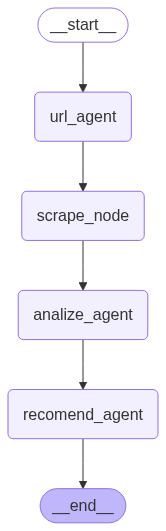

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [2]:
load_dotenv()

llm = init_chat_model("ollama:gemma3:12b")

class MessageURL(BaseModel):
    url: AnyUrl = Field(description="A functional ZonaProp URL based on the user's real estate query")

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    query: Annotated[list, add_messages]
    url: AnyUrl | None

graph_builder = StateGraph(State)


def url_agent(state: State):
    """Create a URL from the query.
    """
    last_message = state["query"][-1]
    url_llm = llm.with_structured_output(MessageURL)

    result = url_llm.invoke([
        {
            "role": "system",
            "content": f"""
                You are an assistant that generates ZonaProp property listing URLs based on the user's message.

                ## ZonaProp URL Format
                Base structure:
                https://www.zonaprop.com.ar/[property-type]-[operation]-[location]-[additional-filters].html

                ### Required Components (must always be included):
                1. **Property Type**
                - departamentos (apartments)
                - casas (houses)
                - ph (Horizontal Property)
                - cocheras (parking)
                - terrenos (land)
                - oficinas (offices)
                - locales (commercial)
                - Combined types: e.g., casas-departamentos-ph

                2. **Operation**
                - venta (sale)
                - alquiler (rent)
                - alquiler-temporal (temporary rental)

                3. **Location**
                - Examples: capital-federal, palermo, la-plata, rosario
                - Can include neighborhoods, cities, or provinces

                ---

                ### Optional Filters (include only if user provides relevant info):
                4. **Rooms (ambientes)**
                - e.g., 1-ambiente, 2-ambientes, mas-de-3-ambientes, desde-2-hasta-3-ambientes

                5. **Bedrooms (habitaciones)**
                - e.g., 1-habitacion, hasta-3-habitaciones, desde-2-hasta-3-habitaciones

                6. **Bathrooms (baños)**
                - e.g., 2-banos, mas-de-1-bano, desde-1-hasta-2-banos

                7. **Garages**
                - e.g., 1-garage, sin-garages, mas-de-1-garage, desde-1-hasta-2-garages

                8. **Price**
                - e.g., menos-200000-dolares, mas-de-100000-pesos, desde-100000-hasta-300000-dolares

                9. **Age**
                - e.g., a-estrenar, hasta-10-anos, mas-de-20-anos

                10. **Sorting**
                - orden-precio-ascendente
                - orden-publicacion-descendente

                11. **Publication Date**
                - publicado-hoy
                - publicado-hace-menos-de-1-semana
                - publicado-hace-menos-de-1-mes

                ---

                ### Rules & Behavior
                - All terms in the URL must be lowercase and hyphen-separated.
                - If key info is missing, **infer as a real estate agent would** or omit the filter.
                - **Always include** property type, operation, and location.
                - **Only output the URL.**
            """
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ])
    return {"url": result.url}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("url_agent", url_agent)
graph_builder.add_edge(START, "url_agent")
graph_builder.add_edge("url_agent", END)


graph = graph_builder.compile()

user_input = input("Enter a message: ")
state = graph.invoke({"query": [HumanMessage(content=user_input)]})

print(state["url"])

https://www.zonaprop.com.ar/departamentos-alquiler-la-plata-desde-3-ambientes-1-habitacion.html
